# Step 1.1: Import libraries

In [76]:
import pandas as pd
import requests
import io
import os
from pathlib import Path
2019
# New imports for modeling and viz
from penaltyblog.models import DixonColesGoalModel, dixon_coles_weights
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Suppress warnings for a cleaner notebook
import warnings
warnings.filterwarnings('ignore')

## 1. Data Acquisition with Understat

Step 1.2: Scrape the data

In [77]:
import penaltyblog as pb

pb.scrapers.Understat.list_competitions()

['DEU Bundesliga 1',
 'ENG Premier League',
 'ESP La Liga',
 'FRA Ligue 1',
 'ITA Serie A',
 'RUS Premier League']

In [78]:
import penaltyblog as pb
import pandas as pd

league = "ENG Premier League"
seasons = ["2018-2019", "2019-2020", "2020-2021", "2021-2022", "2022-2023", "2023-2024", "2024-2025"] 


all_games_data = []
for season in seasons:
    print(f"Fetching data for {league} {season} season...")
    try:
        understat = pb.scrapers.Understat(league, season) 
        season_df = understat.get_fixtures()
        all_games_data.append(season_df)
        
    except Exception as e:
        print(f"--> Could not fetch data for season {season}. Error: {e}")

if all_games_data:
    all_games_df = pd.concat(all_games_data, ignore_index=True)
    print("\nData acquisition complete.")
    print(f"Shape of the combined DataFrame: {all_games_df.shape}")
    display(all_games_df.head())
    display(all_games_df.tail())
else:
    print("\nData acquisition failed. No data to display.")

Fetching data for ENG Premier League 2018-2019 season...
Fetching data for ENG Premier League 2019-2020 season...
Fetching data for ENG Premier League 2020-2021 season...
Fetching data for ENG Premier League 2021-2022 season...
Fetching data for ENG Premier League 2022-2023 season...
Fetching data for ENG Premier League 2023-2024 season...
Fetching data for ENG Premier League 2024-2025 season...

Data acquisition complete.
Shape of the combined DataFrame: (2660, 14)


,understat_id,datetime,team_home,team_away,goals_home,goals_away,xg_home,xg_away,forecast_w,forecast_d,forecast_l,season,competition,date
0,9197,2018-08-10 22:00:00,Manchester United,Leicester,2,1,1.513700,1.73813,0.2812,0.3275,0.3913,2018-2019,ENG Premier League,2018-08-10
1,9202,2018-08-11 17:00:00,Bournemouth,Cardiff,2,0,2.600220,1.50693,0.6773,0.2104,0.1123,2018-2019,ENG Premier League,2018-08-11
2,9201,2018-08-11 17:00:00,Fulham,Crystal Palace,0,2,0.638076,1.07816,0.2004,0.3242,0.4754,2018-2019,ENG Premier League,2018-08-11
3,9200,2018-08-11 17:00:00,Huddersfield,Chelsea,0,3,0.396115,2.31427,0.0214,0.1011,0.8775,2018-2019,ENG Premier League,2018-08-11
4,9198,2018-08-11 14:30:00,Newcastle United,Tottenham,1,2,0.974497,2.58097,0.0800,0.1479,0.7721,2018-2019,ENG Premier League,2018-08-11


,understat_id,datetime,team_home,team_away,goals_home,goals_away,xg_home,xg_away,forecast_w,forecast_d,forecast_l,season,competition,date
2655,26973,2025-05-25 15:00:00,Newcastle United,Everton,0,1,1.159100,1.07279,0.3642,0.3114,0.3244,2024-2025,ENG Premier League,2025-05-25
2656,26972,2025-05-25 15:00:00,Nottingham Forest,Chelsea,0,1,1.580140,1.30874,0.4164,0.3092,0.2744,2024-2025,ENG Premier League,2025-05-25
2657,26977,2025-05-25 15:00:00,Southampton,Arsenal,1,2,0.598144,2.40711,0.0582,0.1366,0.8052,2024-2025,ENG Premier League,2025-05-25
2658,26976,2025-05-25 15:00:00,Tottenham,Brighton,1,4,1.852650,3.11624,0.1249,0.1908,0.6843,2024-2025,ENG Premier League,2025-05-25
2659,26978,2025-05-25 15:00:00,Wolverhampton Wanderers,Brentford,1,1,1.108890,1.97196,0.1792,0.2217,0.5991,2024-2025,ENG Premier League,2025-05-25


## 2. Data Processing and Cleaning 

In [79]:
COLS_TO_KEEP = [
    'datetime',
    'team_home',
    'team_away',
    'goals_home',
    'goals_away',
    'xg_home',
    'xg_away',
    'season'
]

# Create our working DataFrame
football_data = all_games_df[COLS_TO_KEEP].copy()

# Rename 'datetime' to 'date' for simplicity, as in the docs
football_data.rename(columns={'datetime': 'date'}, inplace=True)


# Convert date column to datetime objects
football_data['date'] = pd.to_datetime(football_data['date'])

# Ensure goals and xG are numeric
numeric_cols = ['goals_home', 'goals_away', 'xg_home', 'xg_away']
for col in numeric_cols:
    football_data[col] = pd.to_numeric(football_data[col], errors='coerce')

# Drop any rows where crucial data might be missing after conversion
football_data.dropna(
    subset=['date', 'team_home', 'team_away', 'goals_home', 'goals_away'],
    inplace=True
)

# Convert goal columns to integers
football_data['goals_home'] = football_data['goals_home'].astype(int)
football_data['goals_away'] = football_data['goals_away'].astype(int)

# Sort the dataframe by date, which is crucial for time-decay models
football_data.sort_values(by='date', inplace=True, ascending=True)
football_data.reset_index(drop=True, inplace=True)


print("Processing complete. DataFrame is cleaned and ready for modeling.")
print(f"\nNew shape: {football_data.shape}")
display(football_data.head())
football_data.info()

Processing complete. DataFrame is cleaned and ready for modeling.

New shape: (2660, 8)


,date,team_home,team_away,goals_home,goals_away,xg_home,xg_away,season
0,2018-08-10 22:00:00,Manchester United,Leicester,2,1,1.513700,1.73813,2018-2019
1,2018-08-11 14:30:00,Newcastle United,Tottenham,1,2,0.974497,2.58097,2018-2019
2,2018-08-11 17:00:00,Bournemouth,Cardiff,2,0,2.600220,1.50693,2018-2019
3,2018-08-11 17:00:00,Fulham,Crystal Palace,0,2,0.638076,1.07816,2018-2019
4,2018-08-11 17:00:00,Huddersfield,Chelsea,0,3,0.396115,2.31427,2018-2019


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2660 non-null   datetime64[ns]
 1   team_home   2660 non-null   object        
 2   team_away   2660 non-null   object        
 3   goals_home  2660 non-null   int64         
 4   goals_away  2660 non-null   int64         
 5   xg_home     2660 non-null   float64       
 6   xg_away     2660 non-null   float64       
 7   season      2660 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 166.4+ KB


2.1: Pre-Modeling Data Quality Check 

## 3. Model Training with Time-Decay

In [81]:
print("--- Part 1: Filtering Data ---")
MIN_HOME_GAMES = 38
MIN_AWAY_GAMES = 38

print(f"Applying filter: Removing teams with fewer than {MIN_HOME_GAMES} home or {MIN_AWAY_GAMES} away games.")

home_games = football_data['team_home'].value_counts()
away_games = football_data['team_away'].value_counts()

teams_to_remove_home = home_games[home_games < MIN_HOME_GAMES].index
teams_to_remove_away = away_games[away_games < MIN_AWAY_GAMES].index
teams_to_remove = teams_to_remove_home.union(teams_to_remove_away)

if not teams_to_remove.empty:
    print(f"Teams to remove: {list(teams_to_remove)}")
    football_data_filtered = football_data[
        ~football_data['team_home'].isin(teams_to_remove) &
        ~football_data['team_away'].isin(teams_to_remove)
    ].copy().reset_index(drop=True)
    print(f"New filtered shape: {football_data_filtered.shape}\n")
else:
    print("No teams needed to be removed under this filter.\n")
    football_data_filtered = football_data.copy()


print("--- Part 2: Training Model on Filtered Data ---")
home_goals = football_data_filtered["goals_home"].values
away_goals = football_data_filtered["goals_away"].values
home_team = football_data_filtered["team_home"].values
away_team = football_data_filtered["team_away"].values
dates = football_data_filtered["date"]

# Use a smaller, more stable xi value for the time-decay weights
xi = 0.001
weights = pb.models.dixon_coles_weights(dates, xi=xi)
print(f"Generated {len(weights)} weights with a gentler decay factor (xi) of {xi}.")

# Instantiate the model with the adjusted weights
dixon_coles_model = pb.models.DixonColesGoalModel(
    home_goals,
    away_goals,
    home_team,
    away_team,
    weights=weights
)

print("\nTraining the Dixon-Coles model with the 'Powell' solver...")
try:
    dixon_coles_model.fit(
        minimizer_options={
            'method': 'Powell',
            'maxiter': 5000,
            'disp': False,
        }
    )

    if dixon_coles_model.fitted:
        print("\nModel training complete and successful!")
        print(f"Log-likelihood: {dixon_coles_model.loglikelihood:.2f}")
        print(f"AIC: {dixon_coles_model.aic:.2f}")
    else:
        print("\n--- MODEL TRAINING FAILED ---")
        print("The optimizer finished but did not converge.")

except Exception as e:
    print(f"\n--- MODEL TRAINING FAILED ---")
    print(f"An error occurred: {e}")

--- Part 1: Filtering Data ---
Applying filter: Removing teams with fewer than 38 home or 38 away games.
Teams to remove: ['Cardiff', 'Huddersfield', 'Ipswich', 'Luton', 'West Bromwich Albion']
New filtered shape: (2472, 8)

--- Part 2: Training Model on Filtered Data ---
Generated 2472 weights with a gentler decay factor (xi) of 0.001.

Training the Dixon-Coles model with the 'Powell' solver...

Model training complete and successful!
Log-likelihood: -2771.29
AIC: 5642.59


## 4. Inspect Model Parameters

In [83]:
if 'dixon_coles_model' in locals() and dixon_coles_model.fitted:
    teams = dixon_coles_model.teams
    params = dixon_coles_model.params
    attack_ratings = pd.Series(
        {team: params[f'attack_{team}'] for team in teams},
        name="Attack"
    )
    
    defence_ratings = pd.Series(
        {team: params[f'defence_{team}'] for team in teams},
        name="Defence"
    )
    home_advantage = params['home_advantage']

    print(f"Modelled Home Advantage: {home_advantage:.3f}\n")
    ratings_df = pd.DataFrame({
        'Attack': attack_ratings,
        'Defence': defence_ratings
    })

    print("--- Top 5 Attacking Teams ---")
    display(ratings_df.sort_values(by='Attack', ascending=False).head())
    print("\n--- Top 5 Defensive Teams (Lower is Better) ---")
    display(ratings_df.sort_values(by='Defence', ascending=True).head())

else:
    print("Model not trained successfully. Cannot display parameters.")

Modelled Home Advantage: 0.167

--- Top 5 Attacking Teams ---


,Attack,Defence
Manchester City,1.506985,-1.225611
Liverpool,1.489593,-1.110431
Arsenal,1.368174,-1.170035
Tottenham,1.295020,-0.738139
Newcastle United,1.246930,-0.860722



--- Top 5 Defensive Teams (Lower is Better) ---


,Attack,Defence
Manchester City,1.506985,-1.225611
Arsenal,1.368174,-1.170035
Liverpool,1.489593,-1.110431
Chelsea,1.222518,-0.987487
Everton,0.782744,-0.911103


## 5. Make a Match Prediction 

In [86]:
home_team = "Manchester United"
away_team = "Aston Villa"

# Check if both teams are in our model's vocabulary
if home_team in dixon_coles_model.teams and away_team in dixon_coles_model.teams:
    print(f"--- Prediction for: {home_team} vs {away_team} ---")
    
    # Generate the prediction object
    prediction = dixon_coles_model.predict(home_team, away_team)

    # --- 1. Match Outcome Probabilities (1X2) ---
    print("\nMatch Outcome Probabilities:")
    print(f" P({home_team} Win): {prediction.home_win:.2%}")
    print(f" P(Draw):             {prediction.draw:.2%}")
    print(f" P({away_team} Win):  {prediction.away_win:.2%}")

    # --- 2. Expected Goals (xG) ---
    print("\nExpected Goals (xG):")
    print(f" {home_team}: {prediction.home_goal_expectation:.2f}")
    print(f" {away_team}:  {prediction.away_goal_expectation:.2f}")

else:
    print(f"Cannot make a prediction. One of the teams ('{home_team}' or '{away_team}') is not in the model's dataset.")

--- Prediction for: Manchester United vs Aston Villa ---

Match Outcome Probabilities:
 P(Manchester United Win): 41.06%
 P(Draw):             25.27%
 P(Aston Villa Win):  33.66%

Expected Goals (xG):
 Manchester United: 1.48
 Aston Villa:  1.31


5.1: Visualize Correct Score Probabilities

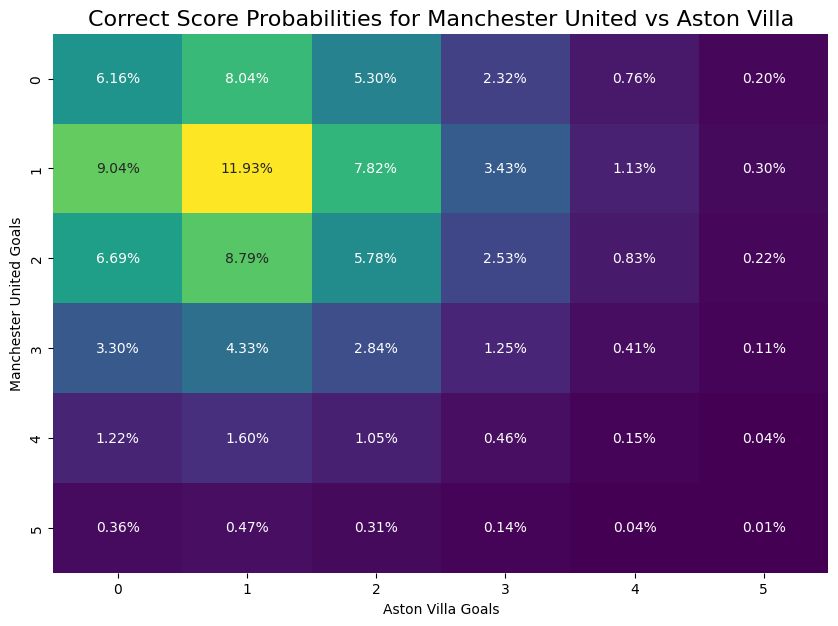

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'prediction' in locals():
    max_goals_to_show = 6
    score_matrix = prediction.grid[:max_goals_to_show, :max_goals_to_show]

    # Create the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(score_matrix, annot=True, fmt=".2%", cmap="viridis", cbar=False)
    
    plt.xlabel(f"{away_team} Goals")
    plt.ylabel(f"{home_team} Goals")
    plt.title(f"Correct Score Probabilities for {home_team} vs {away_team}", fontsize=16)
    plt.show()

else:
    print("Prediction object not found. Please run the prediction cell first.")

## 6. Fetch Player xG Data

In [95]:
from tqdm.auto import tqdm 

PLAYER_STATS_SEASON = "2024-2025"
LEAGUE = "ENG Premier League"

print(f"Fetching fixtures for the {PLAYER_STATS_SEASON} season...")
understat_scraper = pb.scrapers.Understat(LEAGUE, PLAYER_STATS_SEASON)
df_fixtures = understat_scraper.get_fixtures()
match_ids = df_fixtures['understat_id'].unique()
print(f"Found {len(match_ids)} matches. Now collecting all unique players...")

unique_players = {}

for match_id in tqdm(match_ids, desc="Processing Matches"):
    try:
        df_shots = understat_scraper.get_shots(match_id)
        
        if not df_shots.empty:
            df_match_players = df_shots[['player_id', 'player']].copy()
            
            for _, row in df_match_players.iterrows():
                player_id = row['player_id']
                player_name = row['player']
                if player_id not in unique_players:
                    unique_players[player_id] = player_name
                    
    except Exception:
        continue

df_player_ids = pd.DataFrame(
    list(unique_players.items()), 
    columns=['player_id', 'player_name']
).dropna() # Add dropna() for extra safety

print(f"\nProcess complete. Found {len(df_player_ids)} unique players.")
display(df_player_ids.head())

Fetching fixtures for the 2024-2025 season...
Found 380 matches. Now collecting all unique players...


Processing Matches:   0%|          | 0/380 [00:00<?, ?it/s]


Process complete. Found 458 unique players.


,player_id,player_name
0,1228,Bruno Fernandes
1,2248,Casemiro
2,7768,Mason Mount
3,11174,Kobbie Mainoo
4,10552,Alejandro Garnacho


6.1: Fetch Full-Season Stats for Each Player

In [102]:
from tqdm.auto import tqdm
import pandas as pd

PLAYER_STATS_SEASON = "2024-2025"
player_ids = df_player_ids['player_id'].tolist()
player_stats_list = []

print(f"Fetching season stats for all {len(player_ids)} unique players...")

target_season_int = int(PLAYER_STATS_SEASON.split('-')[0])

for pid in tqdm(player_ids, desc="Fetching Player Stats"):
    try:
        player_hist_df = understat_scraper.get_player_season(pid)
        player_hist_df.index = pd.to_numeric(player_hist_df.index)
        cols_to_convert = [col for col in player_hist_df.columns if col not in ['team', 'position']]
        for col in cols_to_convert:
            player_hist_df[col] = pd.to_numeric(player_hist_df[col], errors='coerce')

        if target_season_int in player_hist_df.index:
            season_stats = player_hist_df.loc[[target_season_int]].copy()
            season_stats['player_id'] = pid
            player_stats_list.append(season_stats)

    except Exception as e:
        continue

if player_stats_list:
    df_players = pd.concat(player_stats_list)
    df_players = pd.merge(df_players, df_player_ids, on='player_id')
    
    # --- Clean the final DataFrame ---
    player_cols = {
        'player_name': 'player', 'team': 'team', 'games': 'games',
        'goals': 'goals', 'x_g': 'xg', 'assists': 'assists', 'x_a': 'xa'
    }
    df_players.rename(columns=player_cols, inplace=True)
    
    df_players = df_players[df_players['games'] > 0].reset_index(drop=True)

    print(f"\nSuccessfully fetched and cleaned data for {len(df_players)} players.")
    display(df_players[['player', 'team', 'games', 'goals', 'xg']].sort_values(by='xg', ascending=False).head(10))
else:
    print("\nProcess finished, but no player stats were collected.")

Fetching season stats for all 458 unique players...


Fetching Player Stats:   0%|          | 0/458 [00:00<?, ?it/s]


Successfully fetched and cleaned data for 495 players.


,player,team,games,goals,xg
45,Mohamed Salah,Liverpool,38,29,27.706267
120,Erling Haaland,Manchester City,31,22,23.954593
186,Alexander Isak,Newcastle United,34,23,22.356988
100,Yoane Wissa,Brentford,35,18,20.731060
139,Ollie Watkins,Aston Villa,38,16,18.632458
156,Jean-Philippe Mateta,Crystal Palace,37,14,15.832624
113,Cole Palmer,Chelsea,37,15,15.774236
65,Chris Wood,Nottingham Forest,36,20,15.638655
73,Antoine Semenyo,Bournemouth,37,11,14.549346
227,Raúl Jiménez,Fulham,38,12,14.405358


6.2: Calculate Player Goalscorer Probabilities

In [103]:
import numpy as np

# Part 1: Calculate each player's "xG Share" from last season's data
# --------------------------------------------------------------------
# Calculate the total xG for each team last season
team_total_xg = df_players.groupby('team')['xg'].sum().reset_index().rename(columns={'xg': 'team_total_xg'})

# Merge the team totals back into the main player dataframe
df_players_with_share = pd.merge(df_players, team_total_xg, on='team')

# Calculate each player's share of their team's xG
df_players_with_share['xg_share'] = df_players_with_share['xg'] / df_players_with_share['team_total_xg']


# Part 2: Project player xG for the upcoming match
# --------------------------------------------------------------------
# Get the team-level xG we predicted earlier in Step 5
home_team_xg = prediction.home_goal_expectation
away_team_xg = prediction.away_goal_expectation

# Get the players for the two teams in our predicted match
home_players = df_players_with_share[df_players_with_share['team'] == home_team].copy()
away_players = df_players_with_share[df_players_with_share['team'] == away_team].copy()

# Project each player's xG for this specific match
home_players['match_xg'] = home_team_xg * home_players['xg_share']
away_players['match_xg'] = away_team_xg * away_players['xg_share']

# Combine the players from both teams into one dataframe
df_match_players = pd.concat([home_players, away_players])


# Part 3: Convert player xG to "Anytime Goalscorer" probability
# --------------------------------------------------------------------
# The probability of scoring at least one goal is: 1 - P(0 goals)
# From the Poisson distribution, P(0 goals) = e^(-xG)
df_match_players['prob_anytime_goal'] = 1 - np.exp(-df_match_players['match_xg'])


# Display the final results, sorted by the most likely goalscorers
# --------------------------------------------------------------------
print(f"--- Anytime Goalscorer Probabilities for {home_team} vs {away_team} ---")

display(df_match_players[[
    'player', 
    'team', 
    'prob_anytime_goal',
    'match_xg'
]].sort_values(by='prob_anytime_goal', ascending=False).reset_index(drop=True).head(15))

--- Anytime Goalscorer Probabilities for Manchester United vs Aston Villa ---


,player,team,prob_anytime_goal,match_xg
0,Ollie Watkins,Aston Villa,0.305971,0.365241
1,Bruno Fernandes,Manchester United,0.223614,0.253106
2,Alejandro Garnacho,Manchester United,0.214660,0.241639
3,Morgan Rogers,Aston Villa,0.148764,0.161066
4,Rasmus Højlund,Manchester United,0.139409,0.150135
5,Joshua Zirkzee,Manchester United,0.125042,0.133579
6,Amad Diallo Traore,Manchester United,0.114394,0.121483
7,Jhon Durán,Aston Villa,0.095130,0.099964
8,Marco Asensio,Aston Villa,0.085441,0.089314
9,Mason Mount,Manchester United,0.072483,0.075244


6.3: Visualize Top Goalscorer Probabilities

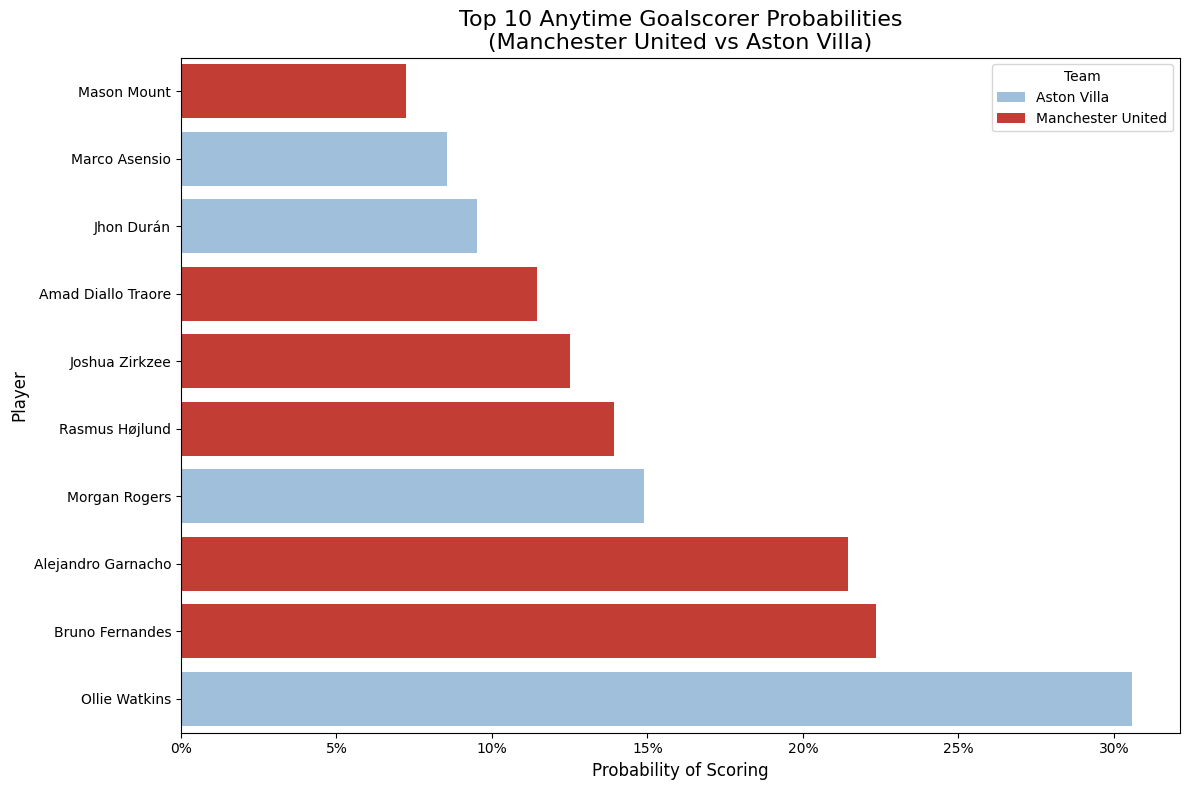

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the dataframe from the previous step exists
if 'df_match_players' in locals():
    
    # Select the top 10 most likely goalscorers
    top_10_scorers = df_match_players.sort_values(by='prob_anytime_goal', ascending=False).head(10)

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='prob_anytime_goal', 
        y='player', 
        hue='team', # Color bars by team
        data=top_10_scorers,
        palette={'Manchester United': '#DA291C', 'Aston Villa': '#95BFE5'}, # Official team colors
        dodge=False # Don't split the bars
    )

    # Add labels and title for clarity
    plt.xlabel("Probability of Scoring", fontsize=12)
    plt.ylabel("Player", fontsize=12)
    plt.title(f"Top 10 Anytime Goalscorer Probabilities\n({home_team} vs {away_team})", fontsize=16)
    
    # Invert y-axis so the top player is at the top
    plt.gca().invert_yaxis()
    
    # Format x-axis as percentage
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    
    plt.legend(title='Team')
    plt.tight_layout()
    plt.show()

else:
    print("Player probabilities DataFrame not found. Please run the previous cell first.")

## 7. Backtest

7: Define Backtest Trainer and Logic

In [111]:
football_data_filtered['b365_h'] = 2.00
football_data_filtered['b365_d'] = 2.00
football_data_filtered['b365_a'] = 2.00
def get_result(row):
    if row['goals_home'] > row['goals_away']: return 'H'
    elif row['goals_home'] < row['goals_away']: return 'A'
    else: return 'D'
football_data_filtered['ftr'] = football_data_filtered.apply(get_result, axis=1)


# 1. The FAULT-TOLERANT Trainer Function
def trainer(ctx):
    """Trains a model but returns None if fitting fails."""
    lookback_data = ctx.lookback
    MIN_GAMES = 38
    home_games = lookback_data['team_home'].value_counts()
    away_games = lookback_data['team_away'].value_counts()
    teams_to_remove = home_games[home_games < MIN_GAMES].index.union(away_games[away_games < MIN_GAMES].index)
    
    if not teams_to_remove.empty:
        lookback_data = lookback_data[
            ~lookback_data['team_home'].isin(teams_to_remove) &
            ~lookback_data['team_away'].isin(teams_to_remove)
        ].copy()

    try:
        weights = pb.models.dixon_coles_weights(lookback_data["date"], 0.001)
        model = pb.models.DixonColesGoalModel(
            teams_home=lookback_data["team_home"],
            teams_away=lookback_data["team_away"],
            goals_home=lookback_data["goals_home"],
            goals_away=lookback_data["goals_away"],
            weights=weights,
        )
        model.fit(minimizer_options={'method': 'Powell', 'disp': False})
        return model
    except ValueError:
        return None


def logic(ctx):
    """Places a bet, but only if the trainer successfully returned a model."""
    fixture, account, model = ctx.fixture, ctx.account, ctx.model
    
    if model is None:
        return 

    if fixture["team_home"] in model.teams and fixture["team_away"] in model.teams:
        pred = model.predict(fixture["team_home"], fixture["team_away"])
        probs = {'H': pred.home_win, 'D': pred.draw, 'A': pred.away_win}
        most_likely_outcome = max(probs, key=probs.get)
        
        if most_likely_outcome == 'H':
            odds, bet_won = fixture["b365_h"], 1 if fixture["ftr"] == "H" else 0
        elif most_likely_outcome == 'D':
            odds, bet_won = fixture["b365_d"], 1 if fixture["ftr"] == "D" else 0
        else:
            odds, bet_won = fixture["b365_a"], 1 if fixture["ftr"] == "A" else 0
            
        account.place_bet(odds, 1, bet_won)

print("Fault-tolerant backtest 'trainer' and 'logic' functions defined successfully.")
print("Please re-run the Step 7.1 cell to start the backtest.")

Fault-tolerant backtest 'trainer' and 'logic' functions defined successfully.
Please re-run the Step 7.1 cell to start the backtest.


7.1: Run Backtest and Visualize Performance

Starting backtest from 2024-08-15 to 2025-06-01...


  0%|          | 0/109 [00:00<?, ?it/s]


--- Backtest Results ---
Total Bets: 76
Successful Bet %: 51.32%
Final Bankroll: 102.00
Profit / Loss: 2.00
Return on Investment (ROI): 2.00%

Generating backtest performance chart...


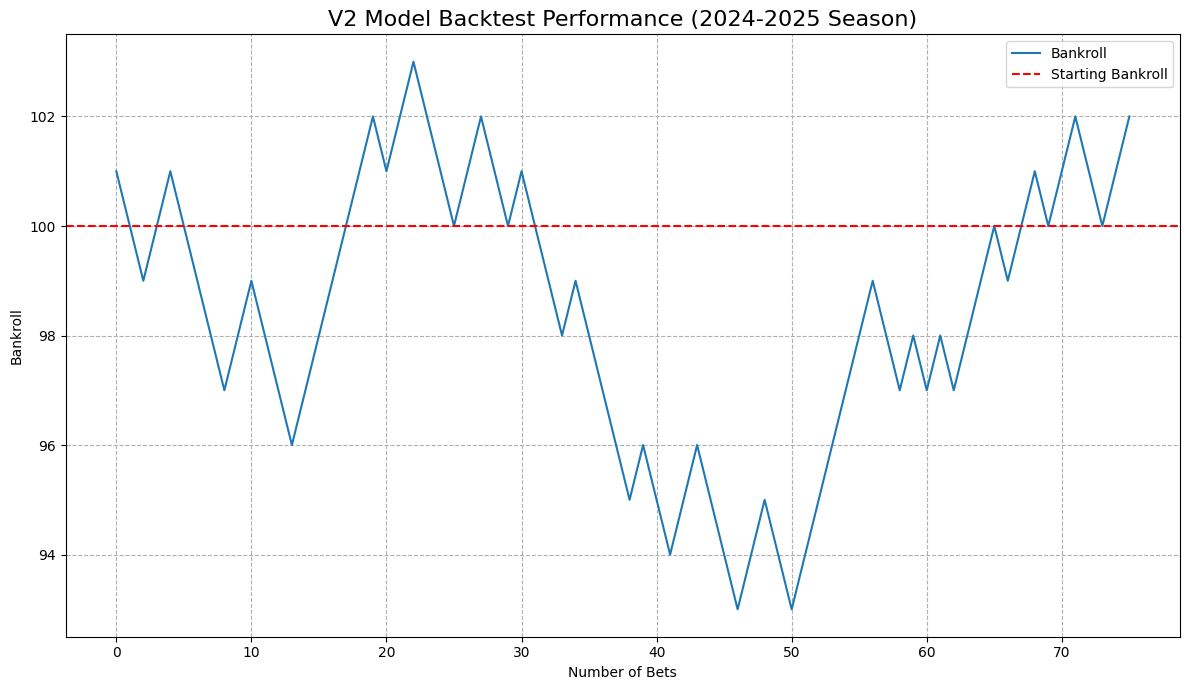

In [112]:
BACKTEST_START = "2024-08-15"
BACKTEST_END = "2025-06-01"

print(f"Starting backtest from {BACKTEST_START} to {BACKTEST_END}...")

# Set up the backtest
backtest = pb.backtest.Backtest(football_data_filtered, BACKTEST_START, BACKTEST_END, True)

backtest.start(100, logic=logic, trainer=trainer)

# Display the final results
results = backtest.results()
print("\n--- Backtest Results ---")
print(f"Total Bets: {results['Total Bets']}")
print(f"Successful Bet %: {results['Successful Bet %']:.2f}%")
print(f"Final Bankroll: {backtest.account.current_bankroll:.2f}")
print(f"Profit / Loss: {results['Profit']:.2f}")
print(f"Return on Investment (ROI): {results['ROI']:.2f}%")

# Plot the performance chart
print("\nGenerating backtest performance chart...")
plt.figure(figsize=(12, 7))
plt.plot(backtest.account.tracker, label="Bankroll")
plt.axhline(y=100, color='r', linestyle='--', label="Starting Bankroll")
plt.title("V2 Model Backtest Performance (2024-2025 Season)", fontsize=16)
plt.xlabel("Number of Bets")
plt.ylabel("Bankroll")
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()